<a href="https://colab.research.google.com/github/wolfinwallst/Machine_Learning_Deep_basis/blob/main/RL_PPO_CartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

오리지널 코드는 A3C 카트폴 파일과 마찬가지로 [github](https://github.com/seungeunrho/minimalRL/blob/master/ppo.py) 를 참조했다.

In [ ]:
# 원본 코드
import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# Hyperparameters
learning_rate = 0.0005
gamma         = 0.98
lmbda         = 0.95
eps_clip      = 0.1
K_epoch       = 3
T_horizon     = 20

class PPO(nn.Module):
    def __init__(self):
        super(PPO, self).__init__()
        self.data = []

        self.fc1   = nn.Linear(4,256)
        self.fc_pi = nn.Linear(256,2)
        self.fc_v  = nn.Linear(256,1)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def pi(self, x, softmax_dim = 0):
        x = F.relu(self.fc1(x))
        x = self.fc_pi(x)
        prob = F.softmax(x, dim=softmax_dim)
        return prob

    def v(self, x):
        x = F.relu(self.fc1(x))
        v = self.fc_v(x)
        return v

    def put_data(self, transition):
        self.data.append(transition)

    def make_batch(self):
        s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []
        for transition in self.data:
            s, a, r, s_prime, prob_a, done = transition

            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            prob_a_lst.append([prob_a])
            done_mask = 0 if done else 1
            done_lst.append([done_mask])

        s,a,r,s_prime,done_mask, prob_a = torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
                                          torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
                                          torch.tensor(done_lst, dtype=torch.float), torch.tensor(prob_a_lst)
        self.data = []
        return s, a, r, s_prime, done_mask, prob_a

    def train_net(self):
        s, a, r, s_prime, done_mask, prob_a = self.make_batch()

        for i in range(K_epoch):
            td_target = r + gamma * self.v(s_prime) * done_mask
            delta = td_target - self.v(s)
            delta = delta.detach().numpy()

            advantage_lst = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float)

            pi = self.pi(s, softmax_dim=1)
            pi_a = pi.gather(1,a)
            ratio = torch.exp(torch.log(pi_a) - torch.log(prob_a))  # a/b == exp(log(a)-log(b))

            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantage
            loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(self.v(s) , td_target.detach())

            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

def main():
    env = gym.make('CartPole-v1')
    model = PPO()
    score = 0.0
    print_interval = 20

    for n_epi in range(10000):
        s, _ = env.reset()
        done = False
        while not done:
            for t in range(T_horizon):
                prob = model.pi(torch.from_numpy(s).float())
                m = Categorical(prob)
                a = m.sample().item()
                s_prime, r, done, truncated, info = env.step(a)

                model.put_data((s, a, r/100.0, s_prime, prob[a].item(), done))
                s = s_prime

                score += r
                if done:
                    break

            model.train_net()

        if n_epi % print_interval==0 and n_epi!=0:
            print("# of episode :{}, avg score : {:.1f}".format(n_epi, score/print_interval))
            score = 0.0

    env.close()

if __name__ == '__main__':
    main()

In [3]:
# 주석 설명을 추가한 코드

import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# 하이퍼파라미터 설정
learning_rate = 0.0005
gamma         = 0.98
lmbda         = 0.95    # GAE(Generalized Advantage Estimation)에서 사용하는 감마의 보정 계수
eps_clip      = 0.1     # 클리핑 범위: 정책 업데이트 시 비율 제한 (old policy와의 차이를 제한)
K_epoch       = 3       # PPO 업데이트를 위해 한 배치 당 에폭 수
T_horizon     = 20      # 한 번에 수집하는 transition(상태, 행동, 보상 등)의 개수

# PPO 모델 클래스 정의 (Policy와 Value 네트워크를 포함)
class PPO(nn.Module):
    def __init__(self):
        super(PPO, self).__init__()
        self.data = []  # 에피소드 동안 수집한 transition 데이터를 저장하는 리스트

        # 상태(state)는 4차원 입력 (CartPole 환경의 관측값: 위치, 속도, 각도, 각속도)
        self.fc1   = nn.Linear(4, 256)  # 첫 번째 완전 연결층: 입력 4차원 -> 은닉층 256차원
        self.fc_pi = nn.Linear(256, 2)   # 정책(Policy) 네트워크: 은닉층 256차원 -> 행동 확률 2개 (왼쪽, 오른쪽)
        self.fc_v  = nn.Linear(256, 1)   # 가치(Value) 네트워크: 은닉층 256차원 -> 상태 가치 1개
        # Adam 옵티마이저를 사용하여 전체 파라미터를 학습
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    # 정책 함수: 주어진 상태에 대해 행동의 확률 분포를 반환
    def pi(self, x, softmax_dim=0):
        x = F.relu(self.fc1(x))
        x = self.fc_pi(x)              # 정책 네트워크 계층 통과
        prob = F.softmax(x, dim=softmax_dim)  # 출력값을 소프트맥스 함수로 확률 분포로 변환
        return prob

    # 가치 함수: 주어진 상태의 가치를 예측
    def v(self, x):
        x = F.relu(self.fc1(x))   # 동일한 첫 번째 계층을 사용, ReLU 적용
        v = self.fc_v(x)          # 가치 네트워크 계층을 통해 상태 가치를 출력
        return v

    # transition 데이터를 저장하는 함수
    def put_data(self, transition):
        # transition: (상태, 행동, 보상, 다음 상태, 행동 선택 확률, 에피소드 종료 여부)
        self.data.append(transition)

    # 저장된 transition 데이터를 배치(batch)로 만드는 함수
    def make_batch(self):
        s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []
        # 저장된 모든 transition을 순회하면서 개별 리스트에 저장
        for transition in self.data:
            s, a, r, s_prime, prob_a, done = transition

            s_lst.append(s)              # 현재 상태 저장
            a_lst.append([a])            # 행동 저장 (리스트 안에 저장하여 shape 맞추기)
            r_lst.append([r])            # 보상 저장 (스케일 조정된 보상)
            s_prime_lst.append(s_prime)  # 다음 상태 저장
            prob_a_lst.append([prob_a])  # 행동을 선택할 때의 확률 저장
            # 에피소드가 종료되었으면(done=True) done_mask는 0, 아니면 1로 설정
            done_mask = 0 if done else 1
            done_lst.append([done_mask])

        # 수집된 데이터를 텐서(tensor)로 변환
        s, a, r, s_prime, done_mask, prob_a = torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
                                              torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
                                              torch.tensor(done_lst, dtype=torch.float), torch.tensor(prob_a_lst)
        self.data = []  # 배치 생성 후 데이터 초기화
        return s, a, r, s_prime, done_mask, prob_a

    # PPO 네트워크를 학습시키는 함수
    def train_net(self):
        s, a, r, s_prime, done_mask, prob_a = self.make_batch() # 저장된 데이터를 배치로 변환

        # 지정한 에폭 수(K_epoch) 만큼 반복하여 정책과 가치 네트워크를 업데이트
        for i in range(K_epoch):
            # TD 타깃 계산: 보상 + 할인율 * 다음 상태의 가치 * 종료 마스크
            td_target = r + gamma * self.v(s_prime) * done_mask
            # TD 오차(Temporal Difference Error) 계산: 타깃과 현재 상태 가치의 차이
            delta = td_target - self.v(s)
            # 역전파에 사용하지 않도록 delta를 detach 후 numpy 배열로 변환
            delta = delta.detach().numpy()

            # Generalized Advantage Estimation (GAE)를 이용하여 advantage 계산
            advantage_lst = []
            advantage = 0.0
            # 시간 역순으로 advantage를 계산 (미래의 delta가 현재의 advantage에 영향을 미침)
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()  # 계산한 advantage 리스트의 순서를 원래대로 뒤집음
            advantage = torch.tensor(advantage_lst, dtype=torch.float)

            pi = self.pi(s, softmax_dim=1) # 현재 상태에 대한 정책 확률 분포 계산
            pi_a = pi.gather(1, a) # 선택한 행동에 해당하는 확률 값을 추출
            # 새로운 정책과 이전 정책의 확률 비율 계산 (ratio = new_prob / old_prob)
            ratio = torch.exp(torch.log(pi_a) - torch.log(prob_a))  # 비율 계산: exp(log(new)-log(old))

            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - eps_clip, 1 + eps_clip) * advantage
            loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(self.v(s), td_target.detach())

            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

# 메인 함수: CartPole 환경에서 PPO 알고리즘 학습 수행
def main():
    env = gym.make('CartPole-v1')
    model = PPO()
    score = 0.0                   # 에피소드당 누적 보상 변수 초기화
    print_interval = 20

    for n_epi in range(10000):
        s = env.reset()
        done = False
        # 에피소드가 종료될 때까지 반복
        while not done:
            # 일정 시간(T_horizon) 동안 transition 데이터 수집
            for t in range(T_horizon):
                # 현재 상태 s를 텐서로 변환하여 정책 네트워크에 입력
                prob = model.pi(torch.from_numpy(s).float())
                m = Categorical(prob)     # 확률 분포 객체 생성 (torch.distributions.Categorical)
                a = m.sample().item()       # 분포로부터 샘플링하여 행동 결정
                s_prime, r, done, info = env.step(a)  # 선택한 행동으로 환경에서 한 스텝 진행

                # transition 데이터 저장: (상태, 행동, 보상(100으로 나누어 스케일 조정), 다음 상태, 행동 확률, 에피소드 종료 여부)
                model.put_data((s, a, r/100.0, s_prime, prob[a].item(), done))
                s = s_prime

                score += r
                if done:
                    break

            model.train_net() # 수집된 데이터를 사용하여 모델 학습

        # 지정한 에피소드 간격마다 평균 보상을 출력
        if n_epi % print_interval == 0 and n_epi != 0:
            print("# of episode :{}, avg score : {:.1f}".format(n_epi, score / print_interval))
            score = 0.0

    env.close()

if __name__ == '__main__':
    main()

<ipython-input-3-e8adf8f2347f>:67: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  s, a, r, s_prime, done_mask, prob_a = torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \


# of episode :20, avg score : 22.2
# of episode :40, avg score : 21.8
# of episode :60, avg score : 40.0
# of episode :80, avg score : 49.3
# of episode :100, avg score : 84.3
# of episode :120, avg score : 125.7
# of episode :140, avg score : 58.9
# of episode :160, avg score : 49.0
# of episode :180, avg score : 189.9
# of episode :200, avg score : 388.4
# of episode :220, avg score : 143.2
# of episode :240, avg score : 306.7
# of episode :260, avg score : 349.6
# of episode :280, avg score : 441.6
# of episode :300, avg score : 270.9
# of episode :320, avg score : 466.4
# of episode :340, avg score : 452.0
# of episode :360, avg score : 500.0
# of episode :380, avg score : 426.9
# of episode :400, avg score : 350.2
# of episode :420, avg score : 430.7
# of episode :440, avg score : 145.9
# of episode :460, avg score : 159.2
# of episode :480, avg score : 229.2
# of episode :500, avg score : 370.1
# of episode :520, avg score : 279.2
# of episode :540, avg score : 258.9
# of episode

`class PPO` 가 핵심이므로 여길 보자:

# of episode :20, avg score : 15.8
# of episode :40, avg score : 20.0
# of episode :60, avg score : 23.4
# of episode :80, avg score : 33.8
# of episode :100, avg score : 35.1
# of episode :120, avg score : 33.2
# of episode :140, avg score : 75.5
# of episode :160, avg score : 144.6
# of episode :180, avg score : 218.4
# of episode :200, avg score : 202.2
# of episode :220, avg score : 223.4
# of episode :240, avg score : 381.9
# of episode :260, avg score : 228.2
# of episode :280, avg score : 240.4
# of episode :300, avg score : 236.8
# of episode :320, avg score : 133.2
# of episode :340, avg score : 223.3
# of episode :360, avg score : 217.6
# of episode :380, avg score : 345.2
# of episode :400, avg score : 348.9
# of episode :420, avg score : 95.0
# of episode :440, avg score : 60.5
# of episode :460, avg score : 139.5
# of episode :480, avg score : 276.9
# of episode :500, avg score : 375.9
# of episode :520, avg score : 408.8
# of episode :540, avg score : 214.0
# of episode :

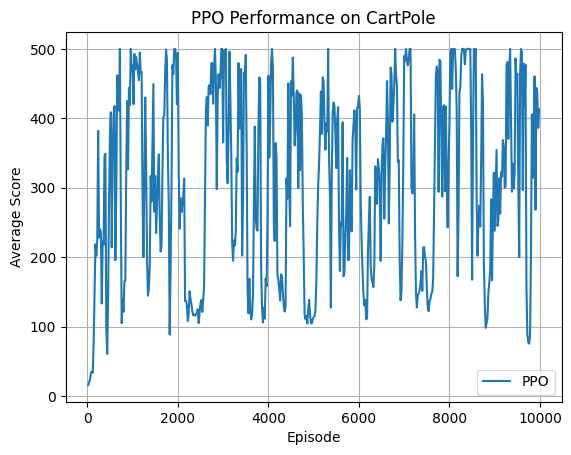

In [4]:
# BM vs PPO 성능 비교를 위해 plot 기능 추가
# 주석 설명을 추가한 코드

import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import matplotlib.pyplot as plt

# 하이퍼파라미터 설정
learning_rate = 0.0005
gamma         = 0.98
lmbda         = 0.95    # GAE(Generalized Advantage Estimation)에서 사용하는 감마의 보정 계수
eps_clip      = 0.1     # epsilon 클리핑 범위: 정책 업데이트 시 비율 제한 (old policy와의 차이를 제한)
K_epoch       = 3       # PPO 업데이트를 위해 한 배치 당 에폭 수
T_horizon     = 20      # 한 번에 수집하는 transition(상태, 행동, 보상 등)의 개수

# PPO 모델 클래스 정의 (Policy와 Value 네트워크를 포함)
class PPO(nn.Module):
    def __init__(self):
        super(PPO, self).__init__()
        self.data = []  # 에피소드 동안 수집한 transition 데이터를 저장하는 리스트

        # 상태(state)는 4차원 입력 (CartPole 환경의 관측값: 위치, 속도, 각도, 각속도)
        self.fc1   = nn.Linear(4, 256)  # 첫 번째 완전 연결층: 입력 4차원 -> 은닉층 256차원
        self.fc_pi = nn.Linear(256, 2)   # 정책(Policy) 네트워크: 은닉층 256차원 -> 행동 확률 2개 (왼쪽, 오른쪽)
        self.fc_v  = nn.Linear(256, 1)   # 가치(Value) 네트워크: 은닉층 256차원 -> 상태 가치 1개
        # Adam 옵티마이저를 사용하여 전체 파라미터를 학습
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    # 정책 함수: 주어진 상태에 대해 행동의 확률 분포를 반환
    def pi(self, x, softmax_dim=0):
        x = F.relu(self.fc1(x))
        x = self.fc_pi(x)              # 정책 네트워크 계층 통과
        prob = F.softmax(x, dim=softmax_dim)  # 출력값을 소프트맥스 함수로 확률 분포로 변환
        return prob

    # 가치 함수: 주어진 상태의 가치를 예측
    def v(self, x):
        x = F.relu(self.fc1(x))
        v = self.fc_v(x)          # 가치 네트워크 계층을 통해 상태 가치를 출력
        return v

    # transition 데이터를 저장하는 함수
    def put_data(self, transition):
        # transition: (상태, 행동, 보상, 다음 상태, 행동 선택 확률, 에피소드 종료 여부)
        self.data.append(transition)

    # 저장된 transition 데이터를 배치(batch)로 만드는 함수
    def make_batch(self):
        s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []
        # 저장된 모든 transition을 순회하면서 개별 리스트에 저장
        for transition in self.data:
            s, a, r, s_prime, prob_a, done = transition

            s_lst.append(s)              # 현재 상태 저장
            a_lst.append([a])            # 행동 저장 (리스트 안에 저장하여 shape 맞추기)
            r_lst.append([r])            # 보상 저장 (스케일 조정된 보상)
            s_prime_lst.append(s_prime)  # 다음 상태 저장
            prob_a_lst.append([prob_a])  # 행동을 선택할 때의 확률 저장
            # 에피소드가 종료되었으면(done=True) done_mask는 0, 아니면 1로 설정
            done_mask = 0 if done else 1
            done_lst.append([done_mask])

        # 수집된 데이터를 텐서로 변환
        s, a, r, s_prime, done_mask, prob_a = torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
                                              torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
                                              torch.tensor(done_lst, dtype=torch.float), torch.tensor(prob_a_lst)
        self.data = []  # 배치 생성 후 데이터 초기화
        return s, a, r, s_prime, done_mask, prob_a

    # PPO 네트워크를 학습시키는 함수
    def train_net(self):
        s, a, r, s_prime, done_mask, prob_a = self.make_batch() # 저장된 데이터를 배치로 변환

        # 지정한 에폭 수(K_epoch) 만큼 반복하여 정책과 가치 네트워크를 업데이트
        for i in range(K_epoch):
            # TD 타깃 계산: 보상 + 할인율 * 다음 상태의 가치 * 종료 마스크
            td_target = r + gamma * self.v(s_prime) * done_mask
            # TD 오차(Temporal Difference Error) 계산: 타깃과 현재 상태 가치의 차이
            delta = td_target - self.v(s)
            delta = delta.detach().numpy() # 역전파에 사용하지 않도록 delta를 detach 후 numpy 배열로 변환

            # Generalized Advantage Estimation (GAE)를 이용하여 advantage 계산
            advantage_lst = []
            advantage = 0.0
            # 시간 역순으로 advantage를 계산 (미래의 delta가 현재의 advantage에 영향을 미침)
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()  # 계산한 advantage 리스트의 순서를 원래대로 뒤집음
            advantage = torch.tensor(advantage_lst, dtype=torch.float)

            pi = self.pi(s, softmax_dim=1) # 현재 상태에 대한 정책 확률 분포 계산
            pi_a = pi.gather(1, a) # 선택한 행동에 해당하는 확률 값을 추출
            # 새로운 정책과 이전 정책의 확률 비율 계산 (ratio = new_prob / old_prob)
            ratio = torch.exp(torch.log(pi_a) - torch.log(prob_a))  # 비율 계산: exp(log(new)-log(old))

            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - eps_clip, 1 + eps_clip) * advantage
            loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(self.v(s), td_target.detach())

            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

# 메인 함수: CartPole 환경에서 PPO 알고리즘 학습 수행
def main():
    env = gym.make('CartPole-v1')
    model = PPO()
    score = 0.0                   # 에피소드당 누적 보상 변수 초기화
    print_interval = 20
    max_ep = 10000

    # plot을 위해 에피소드 번호와 평균 보상을 저장할 리스트 초기화
    episode_list = []
    avg_score_list = []

    for n_epi in range(max_ep):
        s = env.reset()
        done = False
        # 에피소드가 종료될 때까지 반복
        while not done:
            # 일정 시간(T_horizon) 동안 transition 데이터 수집
            for t in range(T_horizon):
                # 현재 상태 s를 텐서로 변환하여 정책 네트워크에 입력
                prob = model.pi(torch.from_numpy(s).float())
                m = Categorical(prob)
                a = m.sample().item() # 분포로부터 샘플링하여 행동 결정
                s_prime, r, done, info = env.step(a)  # 선택한 행동으로 환경에서 한 스텝 진행

                # transition 데이터 저장: (상태, 행동, 보상(100으로 나누어 스케일 조정), 다음 상태, 행동 확률, 에피소드 종료 여부)
                model.put_data((s, a, r/100.0, s_prime, prob[a].item(), done))
                s = s_prime

                score += r
                if done:
                    break

            model.train_net() # 수집된 데이터를 사용하여 모델 학습

        # 지정한 에피소드 간격마다 평균 보상을 출력
        if n_epi % print_interval == 0 and n_epi != 0:
            avg_score = score / print_interval
            print("# of episode :{}, avg score : {:.1f}".format(n_epi, avg_score))
            episode_list.append(n_epi)
            avg_score_list.append(avg_score)
            score = 0.0

    env.close()

    # 학습 완료 후 PPO 성능을 plot으로 시각화
    plt.plot(episode_list, avg_score_list, label="PPO")
    plt.xlabel("Episode")
    plt.ylabel("Average Score")
    plt.title("PPO Performance on CartPole")
    plt.legend()
    plt.grid()
    plt.show()

if __name__ == '__main__':
    main()